In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import os
import pickle
import re
import shutil
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import skimage.io as io
import torch
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image, ImageOps
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval


def add_border(input_image, border, color):
    #img = Image.open(input_image)
    if isinstance(border, int) or isinstance(border, tuple):
        #debug# print(input_image, border, color)
        if not input_image.mode == 'RGB':
            rgbimg = Image.new("RGB", input_image.size)
            rgbimg.paste(input_image)
            input_image = rgbimg
        bimg = ImageOps.expand(input_image, border=border, fill=color)
    else:
        raise RuntimeError('Border is not an integer or tuple!')
    return bimg


def combine(query, support):
    w1, h1 = query.size
    w2, h2 = support.size
    if w2 > w1:
        support.resize(w1, h2*w1/w2)
        w2, h2 = support.size
    new_img = Image.new('RGB', (w1, h1+h2))
    y_offset = 0
    new_img.paste(support, (0, 0))
    new_img.paste(query, (0, h2))
    return new_img


def combine_images(images):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_img = Image.new('RGBA', (total_width, max_height), (255, 0, 0, 0))
    x_offset = 0
    for im in images:
        new_img.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    # patch_box = Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, linewidth=0, linestyle="dashed", alpha=0, facecolor="none")
    return new_img


def get_one_croped_image(query_img_id, target_cat=None, cids=None, output_dir="", json_to_cid=None):
    support_ids = pair_df[pair_df.img_id ==
        query_img_id].support_ann_ids.values[0]
    support_anns = [
        ann for ann in all_support_anns if ann["id"] in support_ids]
    global cat_f
    if target_cat:
        support_anns = [
            ann for ann in support_anns if ann["category_id"] in target_cat]
    if cids:
        support_anns = [
            ann for ann in support_anns if ann["category_id"] in cids]

    support_ids = [ann["id"] for ann in support_anns]
    # support_cids = [ann["category_id"] for ann in support_anns]
    # cropped_boxes = []
    return support_anns, support_ids
#     for sid, support_ann in zip(support_ids, support_anns):
#         img = coco_s.loadImgs(support_ann['image_id'])[0]
#         #lvis use the example from train
#         img_file = '../datasets/coco/train2017/%s'%img['file_name']
#         I = Image.open(img_file)
#         [x, y, w, h] = support_ann["bbox"]
#         box = [x, y, x+w, y+h]
#         cropped_box = I.crop(box)
#         box_size = cropped_box.size
#         # print(box_size)
#         long_side = max(box_size)
#         scaling_factor = 300/long_side
#         new_size = (int(box_size[0]*scaling_factor), int(box_size[1]*scaling_factor))
#         cropped_box=cropped_box.resize(new_size)

#         #if support_ann["category_id"] in cat_r:
#         color = (255, 0, 0)
#         #elif support_ann["category_id"] in cat_c:
#         #    color = (0,255,0)
#         #else:
#         #    color = (0,0,255)
#         # cropped_box = add_border(cropped_box, 5, color)
# #       #plt.savefig('{0}/output-{1}-{2}.png'.format(root, img['id'], classes), dpi=300, bbox_inches='tight',pad_inches = 0)
#         cropped_boxes.append(cropped_box)
#         cropped_box.save("{0}{1}.png".format(output_dir, sid))
#     return combine_images(cropped_boxes), support_cids


def get_image_and_th(result, target_cat):
    img_score = defaultdict()
    img_thresholds = defaultdict()
    for item in result:
        # consider iouThr 0.5
        if target_cat:
            E = [i for i in item if i["category_id"] in target_cat]
        else:
            E = item
        if not E:
            continue
        dtScores = np.concatenate([e['dtScores'] for e in E])
        # dtScores = np.stack(E['dtScores'])
        inds = np.argsort(-dtScores, kind='mergesort')

        dtScoresSorted = dtScores[inds]
        dtm = np.concatenate([e['dtMatches'][0] for e in E])[inds]
        dtIg = np.concatenate([e['dtIgnore'][0] for e in E])[inds]
        #dtm = np.stack([E['dtMatches'][0] for e in E])[inds]
#         dtm  = np.stack([e[0] for e in E['dtMatches']])[inds]
#         dtIg = np.stack([e[0] for e in E['dtIgnore']])[inds]
        tps = np.logical_and(dtm,  np.logical_not(dtIg))
        fps = np.logical_and(np.logical_not(dtm), np.logical_not(dtIg))
        tp_sum = np.cumsum(tps).astype(dtype=np.float)
        fp_sum = np.cumsum(fps).astype(dtype=np.float)

        tp = np.array(tp_sum)
        fp = np.array(fp_sum)
        npig = len(tp)
        rc = tp / npig
        pr = tp / (fp+tp+np.spacing(1))
        q = np.zeros((R,))
        ss = np.zeros((R,))

        try:
            for ri, pi in enumerate(inds):
                q[ri] = pr[pi]
                ss[ri] = dtScoresSorted[pi]
        except:
            pass
        beta = 0.5
        f1 = ((1+beta**2)*pr*rc)/(beta**2*pr+rc)
        if not pr.any() or not rc.any() or np.all(np.isnan(f1)):
            continue
            import pdb; pdb.set_trace()

        precision = np.array(q)
        scores = np.array(ss)
        mean_precision = np.mean(precision)
        mean_precision = np.max(f1)
        image_id = [i["image_id"] for i in E][0]
        img_score[image_id] = mean_precision
        th = dtScoresSorted[np.nanargmax(f1)] - 0.00001
        img_thresholds[image_id] = th
    return img_score, img_thresholds


def get_resize_from_size(box_size, max_size):
    long_side = max(box_size)
    scaling_factor = max_size/long_side
    new_size = (int(box_size[0]*scaling_factor),
                int(box_size[1]*scaling_factor))
    return new_size


def save_outputs(imgIds, thresholds, root, cocoGT, cocoDt, target_cat=None,):
    json_category_id_to_contiguous_id = {
        v: i + 1 for i, v in enumerate(coco.getCatIds())
    }
    if not os.path.exists(root):
        os.makedirs(root)
    images = cocoDt.loadImgs(imgIds)
    counter = 0

    for img, th in zip(images, thresholds):
        #if counter > 50:
        #    break
        output_dir = root+"/"+str(img['id']) + "/"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # print(output_dir)
        annIds = cocoDt.getAnnIds(img['id'], iscrowd=None)
        anns = cocoDt.loadAnns(annIds)
        if target_cat:
            anns = [a for a in anns if a["category_id"] in target_cat]
        anns = [a for a in anns if a["score"] > th]
        # anns = [a for a in anns if a["category_id"]==1]
        if len(anns) == 0:
            print("no annotations")
            continue
        if target_cat:
            cids = [ann["category_id"]
                for ann in anns if ann["category_id"] in target_cat]
        else:
            cids = [ann["category_id"] for ann in anns if ann["category_id"]]
        #if (not(set(cids)&set(cat_r)) and not(set(cids)&set(cat_c))):
        #if not(set(cids)&set(cat_r)):
        #    continue
        #if not len(set(cids)) == 1: # and not len(set(cids)) == 3:
        #     continue
        # print((set(cids)&set(cat_r)),(set(cids)&set(cat_c)))
        #if target_cat and (not set(cids) & set(target_cat)):
        #    print("no target categories")
        #    continue
        if not cids:
            print("no target categories")
            continue
        counter += 1
        if target_cat:
            anns = [ann for ann in anns if ann["category_id"] in target_cat]

        plt.axis('off')
        I = Image.open('../datasets/coco/val2017/%s' % img['file_name'])
        # from shutil import copyfile
        # copyfile('../datasets/coco/val2017/%s'%img['file_name'], output_dir+img['file_name'])
        max_size = max(I.size)
        w, h = I.size
#         if max_size > 1000.0:
#             scale = 1000.0/max_size
#             w = int(w*scale)
#             h = int(h*scale)
#             I = I.resize(w, h)
#             w, h = I.size
        scale = 800/h
        w = int(w*scale)
        h = int(h*scale)
        figsize = (w/300, h/300)
        # I = I.resize((w, h))
        # plt.autoscale(False)
        plt.imshow(I);  # plt.axis('off')
        plt.savefig(output_dir+img['file_name'], dpi=300,
                    bbox_inches='tight', pad_inches=0, figsize=figsize)
        # draw GT anns
        annIds_gt = cocoGt.getAnnIds(img['id'], iscrowd=None)
        anns_gt = cocoGt.loadAnns(annIds_gt)
        anns_gt = [ann for ann in anns_gt if ann["category_id"] in set(cids)]
        # anns_gt = [ann for ann in anns_gt if ann["iscrowd"] == 0]
        for i, ann in enumerate(anns_gt):
            anns_gt[i]["category_id"] = json_category_id_to_contiguous_id[ann["category_id"]]
        coco.showAnns(anns_gt, class_names=class_names,
                      show_mask=True,
                      show_bbox=True,
                      box_width=1,
                      draw_caption=True,
                      text_size=10,
                     )

        plt.savefig(output_dir + "gt_" + img['file_name'], dpi=300,
                    bbox_inches='tight', pad_inches=0, figsize=figsize)
        plt.clf()
        plt.cla()
        plt.axis('off')

        plt.imshow(I)
        draw_caption=True
        # print([ann["category_id"] for ann in anns])
        for i, ann in enumerate(anns):
            anns[i]["category_id"]=json_category_id_to_contiguous_id[ann["category_id"]]
        # print([ann["category_id"] for ann in anns])
        # assert False
        coco.showAnns(anns, class_names=class_names,
                      show_mask = True,
                      show_bbox = True,
                      box_width = 1,
                      draw_caption = draw_caption,
                      text_size = 10
                     )
        support_anns, support_ids= get_one_croped_image(
            img['id'],
            target_cat,
            cids, output_dir,
        )
        support_cids = [ann["category_id"] for ann in support_anns]
        support_cids = [json_category_id_to_contiguous_id[c] for c in support_cids]
        classes = [class_names[i] for i in support_cids]

        for sid, support_ann, kls in zip(support_ids, support_anns, classes):
            img = coco_s.loadImgs(support_ann['image_id'])[0]
            img_file = '../datasets/coco/val2017/%s'%img['file_name']
            I = Image.open(img_file)
            [x, y, w, h] = support_ann["bbox"]
            box = [x, y, x+w, y+h]
            cropped_box = I.crop(box)
            box_size = cropped_box.size
            # long_side = max(box_size)
            # scaling_factor = 400/long_side
            new_size = get_resize_from_size(max_size=400, box_size=box_size)
            #(int(box_size[0]*scaling_factor), int(box_size[1]*scaling_factor))
            # new_size = (400, 400)
            cropped_box=cropped_box.resize(new_size)
            cropped_box.save("{0}{1}.png".format(output_dir, kls))        
        
        classes = ','.join(classes)
        output_file = '{0}pred_{1}_{2}.png'.format(output_dir, img['id'], classes)
        plt.savefig(output_file, dpi=300, bbox_inches='tight',pad_inches=0)
        
        # concat_img = combine_images([cropped_box[0], ])
        
        plt.clf()
        plt.cla()
        plt.close()


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
annFile = "../datasets/coco/annotations/instances_val2017.json"
# annFile = "../datasets/voc/VOC2012/Annotations/pascal_val2012_instance.json"
# lvis_v0.5_train.json_common_rare
# annFile = "../datasets/lvis/annotations/lvis_v0.5_val.json_common_rare"
coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
all_cats=[cat['name'] for cat in cats]
# cat_r = [c["id"] for c in cats if c["frequency"] == "r"]
# cat_c = [c["id"] for c in cats if c["frequency"] == "c"]
# cat_f = [c["id"] for c in cats if c["frequency"] == "f"]
class_names = ["BG"] + all_cats
class_names  = [(re.sub(r" ?\([^)]+\)", "", c)) for c in class_names]
annFile_s = annFile
# annFile_s = "../datasets/lvis/annotations/lvis_v0.5_train.json_common_rare"
coco_s=COCO(annFile_s)
all_support_anns = coco_s.dataset['annotations']
# all_support_anns = [ann for ann in all_support_anns if ann["category_id"] not in cat_f]

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [5]:
# Let's show gt and try to rotate it

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Loading and preparing results...
DONE (t=5.86s)
creating index...
index created!


/home/henrywang/.conda/envs/lvis/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/henrywang/.conda/envs/lvis/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in true_divide


no annotations


OSError: [Errno 36] File name too long: 'outputs_coco_novel_1/466256/pred_394940_dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table,dining table.png'

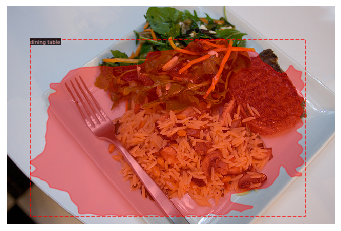

In [3]:
# i = [a["id"] for i, a in enumerate(anns["categories"]) if i % 4 == (split-1)]
# i = [a["id"] for i, a in enumerate(anns["categories"]) if not i % 4 == (split-1)]
cids = coco.getCatIds()
for i in [1,3,4]: #range(2,3):
    #if i < 4:
    target_cat = [k for j, k in enumerate(cids) if j%4 == (i-1)]
    # target_cat = [1, 3, 18, 20]
    # target_cat = None
    #print(target_cat)
    #continue
    #else:
    #    target_cat = [j for j in range(1, 81) if j%4 == 0]
    # log_folder = "lvis_val_cocostyle_test_{0}".format(i)
    # model_path = "../models/coco_{0}_mil_no_aff".format(i)
    model_path = "../models/coco_{0}_mil12_aff005".format(i)
    log_folder = "inference/coco_2017_val"
#     model_path = "../models/lvis_mil12_aff005_test"
#     log_folder = "inference/lvis_val_cocostyle"
    pair_df_file = "{0}/features/all_pair_df.pickle".format(model_path)
    with open(pair_df_file, "rb") as f:
        pair_df = pickle.load(f)
    seg_file = "{0}/{1}/segm.json".format(model_path, log_folder)
    cocoGt = COCO(annFile)
    cocoDt = coco.loadRes(seg_file)
    # coco = cocoDt
    log_file = model_path + "/" + log_folder + "/coco_evaluate_result.pkl"
    if os.path.isfile(log_file):
        with open(log_file, 'rb') as handle:
            coco_evaluate_result = pickle.load(handle)
    else:
        # output_folder="../lvis"
        ann_type_id=0
        split=0

        annType = ['segm', 'bbox', 'keypoints']
        annType = annType[ann_type_id]  # specify type here
        prefix = 'instances'
        # dataDir = '../datasets/lvis/annotations'
        # annFile = '%s/lvis_v0.5_val.json_common_rare' % (dataDir) # 
        
        resFile = '%s/%s/%s.json' % (model_path, log_folder, annType)
#         targets_fname = "%s/%s/target.pth" % (model_path, log_folder)
#         if os.path.isfile(targets_fname):
#             targets = torch.load(targets_fname)
#         else:
#             targets = None
        cocoDt = cocoGt.loadRes(resFile)
        imgIds = sorted(cocoGt.getImgIds())
        imgIds = imgIds
        cocoEval = COCOeval(cocoGt, cocoDt, annType) #, split=split, targets=targets
        cocoEval.params.imgIds = imgIds
        
        coco_evaluate_result = cocoEval.evaluate_debug()
        with open(log_file, "wb") as handle:
            pickle.dump(coco_evaluate_result, handle)

    
    recThrs = np.linspace(.0, 1.00, np.round((1.00 - .0) / .01) + 1, endpoint=True)
    R = len(recThrs)
#     coco_evaluate_result = [result for result in coco_evaluate_result if result]
    _img_score, _img_thresholds = get_image_and_th(coco_evaluate_result, target_cat)
    img_ids = np.array([k for k, v in _img_score.items()])
    img_scores = np.array([v for k, v in _img_score.items()])
    img_thresholds = np.array([v for k, v in _img_thresholds.items()])
    inds = np.argsort(-img_scores, kind='mergesort')
    inds = inds[0:1000]
    img_thresholds = img_thresholds[inds]
    img_scores = img_scores[inds]
    test_images = img_ids[inds]
    img_output_folder = "outputs_coco_novel_{0}".format(i)
    # img_output_folder = img_output_folder + "_" + str(i)
    save_outputs(test_images, img_thresholds, img_output_folder, cocoGt, cocoDt, target_cat)

print("done")